<a href="https://colab.research.google.com/github/jv-porto/hate-speech/blob/main/src/models/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Referências
- [Análise de sentimentos em português utilizando Pytorch e Python](https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0)
- [Ceweb.br - Bert_HateSpeech_Classification](https://github.com/cewebbr/Bert_HateSpeech_Classification)

# Análise de sentimentos em português utilizando Pytorch e Python

Link: https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

## O que é o BERT?
Uma técnica de Processamento de Linguagem Natural (NLP) que apresentou resultados impressionantes em tarefas como prever a continuação de frases (SWAG) e destacar em um texto qual seria a resposta para uma dada pergunta (SQuAD).

O BERT pode ser aplicado em diferentes contextos, como na identificação de sentimentos de frases que será desenvolvida neste projeto. Para adaptá-lo, é necessário criar um classificador e realizar pequenas mudanças durante a etapa de treinamento do modelo - esse processo é chamado de Fine-Tunning.

# Arquitetura
Antes de explorar a construção do modelo, é necessário entender como o BERT funciona. A principal inovação que ele trouxe foi a aplicação do treinamento bidirecional em transformers — essa técnica permite um profundo entendimento do contexto trabalhado.

Os transformers utilizados no BERT são mecanismos de atenção que aprendem relações entre palavras. Eles são compostos de codificadores (encoders) que leem um pedaço de texto de uma só vez e geram uma representação para cada palavra baseado no contexto em que elas estão inseridas.

Por exemplo, a palavra graça seria representada de uma forma na frase “O palhaço faz graça para sobreviver”e de outra em “Se conselho fosse bom, ninguém daria de graça”. Ela assume significados diferentes dependendo do contexto.

O BERT é basicamente uma pilha de codificadores de transformers. No artigo do modelo, são apresentadas as versões com 12 (base) e 24 (large) camadas. As frases a serem analisadas são quebradas em pequenos segmentos e cada um deles recebe um código chamado de token. Esses tokens são utilizados para alimentar o modelo.

## Coleta de dados
Para criar o classificador de sentimentos é necessário um dataset de dados rotulados. Uma boa fonte de informações são as avaliações dos usuários em aplicativos da Google Play Store. Nelas, cada texto está associado a um número de 1 a 5 que indica o grau de satisfação das pessoas com as aplicações e consequentemente seus sentimentos em relação às suas experiências.

Com o auxilio do site AppAnnie, selecionou-se os Top 10 apps de comida mais baixados no Brasil e seus respectivos IDs. Essa informações serão utilizadas para extrair os dados de avaliações dos usuários utilizando o pacote Google-Play-Scraper.

In [ ]:
!pip install google_play_scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

## Coleta e Tratamento de dados

In [ ]:
apps_ids = ['br.com.brainweb.ifood', 'com.cerveceriamodelo.modelonow','com.mcdo.mcdonalds', 'habibs.alphacode.com.br',
'com.ubercab.eats', 'com.grability.rappi','burgerking.com.br.appandroid', 'com.vanuatu.aiqfome']

app_infos = []

for ap in tqdm(apps_ids):
    info = app(ap, lang='en', country='us')
    del info['comments']
    app_infos.append(info)

100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


In [ ]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.head(2)

,title,description,descriptionHTML,summary,installs,minInstalls,realInstalls,score,ratings,reviews,...,contentRating,contentRatingDescription,adSupported,containsAds,released,lastUpdatedOn,updated,version,appId,url
0,iFood comida e mercado em casa,"Buy in markets, restaurants, pharmacies and pe...","Buy in markets, restaurants, pharmacies and pe...","Order food delivery, market, drinks, pharmacy ...","100,000,000+",100000000,121433127,4.599282,13236304,2690,...,Everyone,None,False,False,"Apr 25, 2012","Oct 14, 2024",1728925162,10.39.0,br.com.brainweb.ifood,https://play.google.com/store/apps/details?id=...
1,Zé Delivery de Bebidas,Zé Delivery: the biggest drinks app in the cou...,Zé Delivery: the biggest drinks app in the cou...,"Delivery of drinks at a low price, with fast d...","10,000,000+",10000000,24853278,4.689394,1288544,305,...,Mature 17+,None,False,False,"Aug 19, 2016","Sep 9, 2024",1725912694,24.36.1,com.cerveceriamodelo.modelonow,https://play.google.com/store/apps/details?id=...


Feito isso, é possível coletar as avaliações dos usuários para cada um dos aplicativos. Como os textos serão divididos em três classes possíveis (positivo, negativo ou neutro) e objetivo é obter um dataset o mais balanceado possível, selecionou-se 400 amostras de avaliações com score 3 e 200 de cada uma das outras.

In [ ]:
app_reviews = []

for ap in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='pt',
                country='br',
                sort=sort_order,
                count= 400 if score == 3 else 200,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            app_reviews.extend(rvs)

100%|██████████| 8/8 [00:28<00:00,  3.61s/it]


In [ ]:
df = pd.DataFrame(app_reviews)
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,95f61ca3-de0f-466b-8aef-c29e95fd28aa,Luiz Gallas,https://play-lh.googleusercontent.com/a-/ALV-U...,Não estou conseguindo inserir nenhum cartão de...,1,67,10.36.0,2024-10-06 15:20:15,None,NaT,10.36.0,most_relevant,br.com.brainweb.ifood
1,2ff55baa-1439-4777-b042-fefd8497edf9,Dan,https://play-lh.googleusercontent.com/a-/ALV-U...,Aí você gasta minutos valiosos montando seu pe...,1,97,10.36.0,2024-10-05 16:07:57,None,NaT,10.36.0,most_relevant,br.com.brainweb.ifood
2,ca26bf3c-fe4e-4975-8d5e-e1cdff78f91c,Leandro Antunes Bitencourt,https://play-lh.googleusercontent.com/a-/ALV-U...,Os restaurantes não tem limite de tempo para c...,1,35,10.36.0,2024-10-07 00:43:25,None,NaT,10.36.0,most_relevant,br.com.brainweb.ifood
3,a6b6ef42-3a91-4b42-b44a-e8b21a2cb5b5,ana cristina silva,https://play-lh.googleusercontent.com/a-/ALV-U...,O mercado oferece entrega grátis a partir de 1...,1,6,10.39.0,2024-10-12 14:23:53,None,NaT,10.39.0,most_relevant,br.com.brainweb.ifood
4,3e834a2e-8d72-448b-bc55-1ba3e997de46,Marcos Vinicius,https://play-lh.googleusercontent.com/a-/ALV-U...,O ifood já foi melhor. Essa nova versão tem tr...,1,178,10.36.0,2024-09-29 02:47:35,None,NaT,10.36.0,most_relevant,br.com.brainweb.ifood
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,920363fb-aa2e-46c9-bd1e-48e56babc0b2,marta estela,https://play-lh.googleusercontent.com/a-/ALV-U...,"Fácil de usar, linguagem legal",5,0,None,2024-09-20 23:36:37,"Olá, Marta, tudo bem? Ficamos felizes em saber...",2024-09-25 21:01:56,None,newest,com.vanuatu.aiqfome
19196,b4fcadbe-a9bb-4d30-a07f-95af3f1cc311,Janice Siqueira Rodrigues,https://play-lh.googleusercontent.com/a-/ALV-U...,Ah q fome! Eu posso comer de noite,5,0,None,2024-09-20 23:14:41,"Olá, Janice, tudo bem? Muito obrigada pelo fee...",2024-09-25 21:02:48,None,newest,com.vanuatu.aiqfome
19197,eb81ccaa-3bab-4ae8-81f3-0cd6ba94c075,Gabriel Do santos,https://play-lh.googleusercontent.com/a/ACg8oc...,Amo,5,0,14.11.0,2024-09-20 22:51:03,"Olá, Gabriel, tudo bem? Agradecemos demais pel...",2024-09-25 21:03:34,14.11.0,newest,com.vanuatu.aiqfome
19198,59b5044c-d400-41c1-9124-61575bfdd8d6,Pamela Biao,https://play-lh.googleusercontent.com/a-/ALV-U...,muito boa,5,0,None,2024-09-20 21:48:49,"Olá, Pamela, tudo bem? Agradecemos demais pelo...",2024-09-24 20:30:38,None,newest,com.vanuatu.aiqfome


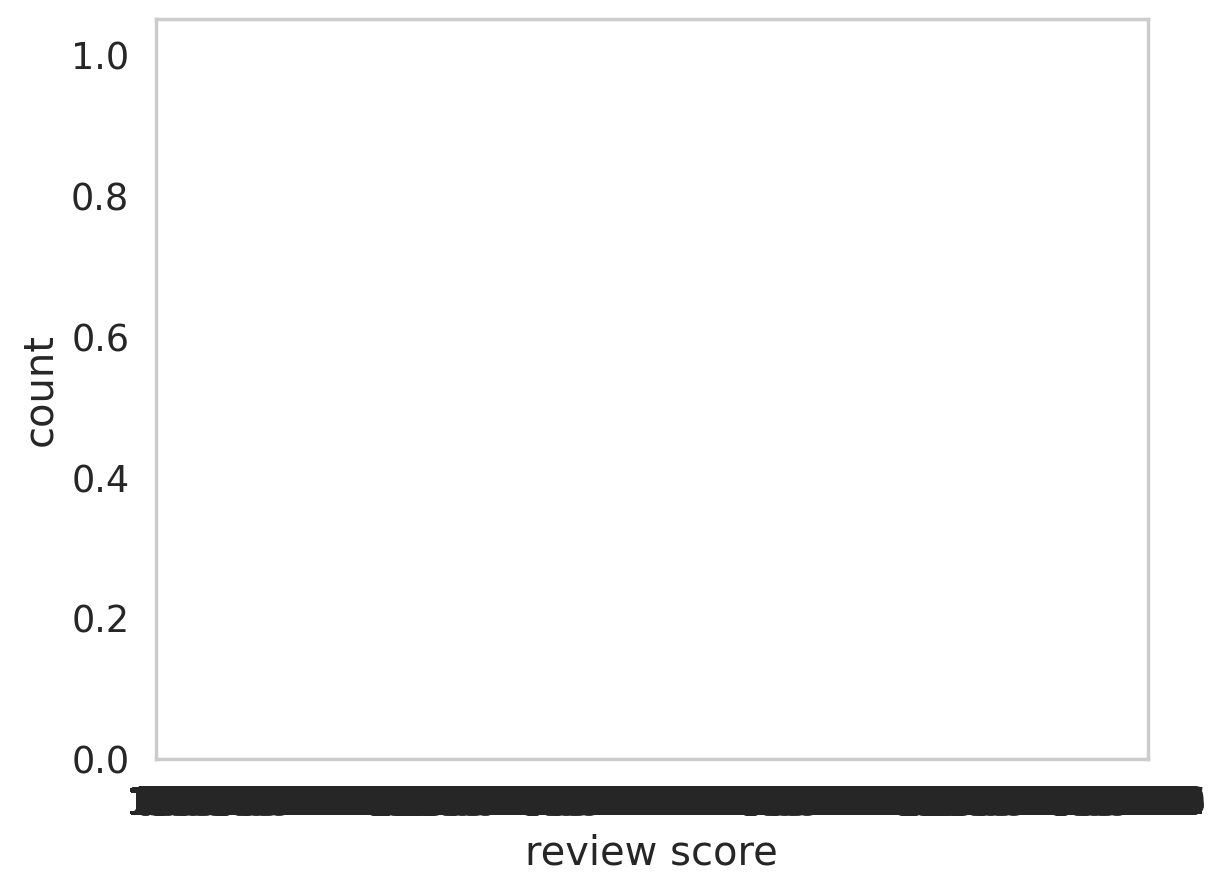

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

A ideia é que sejam atribuídos sentimentos para avaliações a partir dos scores seguindo a seguinte divisão:
- 1 - 2: Negativo
- 3: Neutro
- 4 - 5: Positivo

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

<ipython-input-12-44691682706e>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


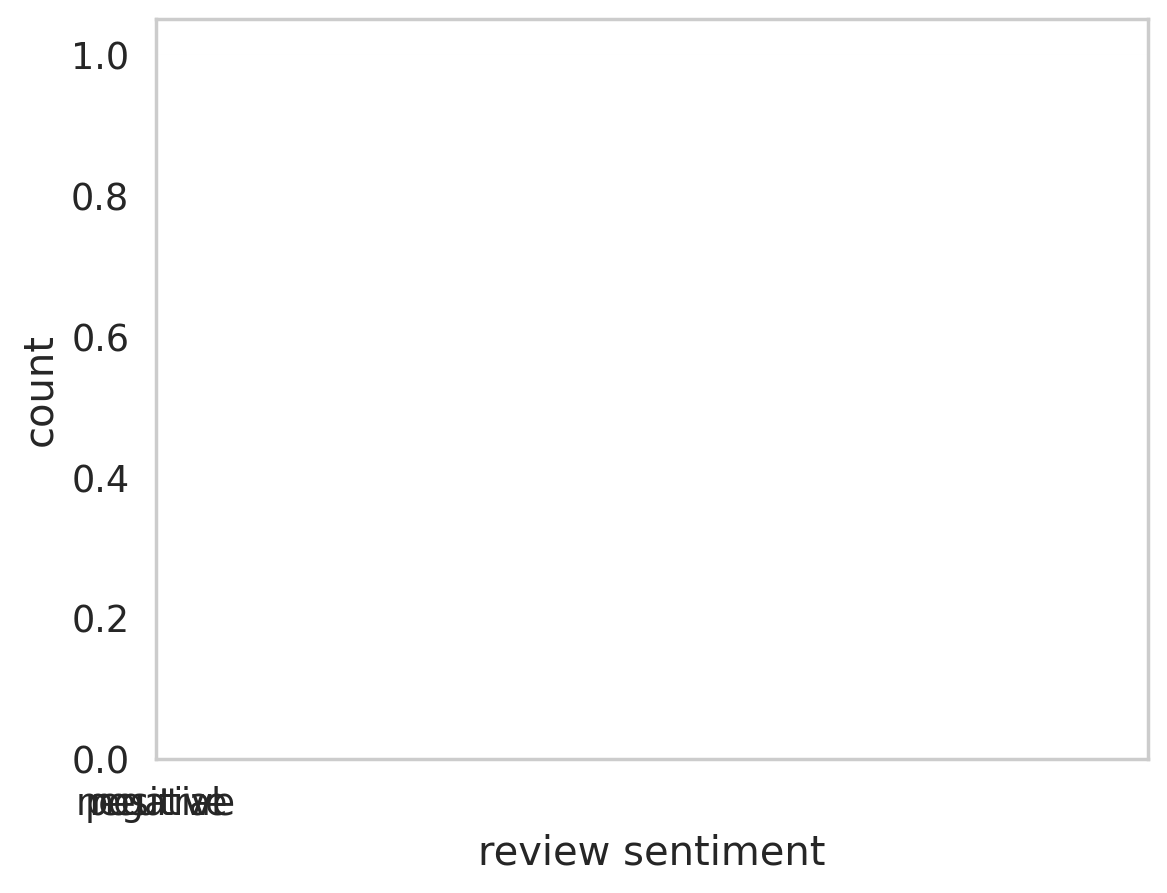

In [ ]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Com os dados coletados, a última etapa é salvar as informações em um csvque servirá de entrada para o treino do classificador.

In [ ]:
df.to_csv('reviews.csv', index=None, header=True)

## Pré-processamento dos dados
Conforme citado anterioremente, o BERT requer que os textos de entrada sejam convertidos em tokens. Para isso, será utilizada a biblioteca transformers do Hugging Face. Ela precisa ser instalada e um tokenizer inicializado com um BERT pré-treinado. Como esse projeto baseia-se na análise de textos em portugês, utilizou-se o BERTimbau, um modelo que foi treinado no dataset BrWaC (Brazilian Web as Corpus).

In [ ]:
!pip install -qq transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
sample_txt = 'Quem conta um conto aumenta um ponto'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Quem conta um conto aumenta um ponto
   Tokens: ['Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto']
Token IDs: [15807, 1284, 222, 12059, 8101, 222, 2009]


No entanto, para cumprir os requisitos de entrada do BERT é preciso ciar vetores de 0s e 1s chamados attention mask, que indicam quais token devem ser considerados como válidos, e adicionar mais três tokens especiais nos textos:

[SEP] (102)- Marca o fim de uma frase

[CLS] (101)- Deve ser colocado no inicio de cada frase para o BERT saber que trata-se de um problema de classificação.

[PAD] (0)- Tokens de valor 0 que devem ser adicionados às sentenças para garantir que todas tenham o mesmo tamanho

Isso será feito com o auxílio do método encode_plus(), conforme o exemplo abaixo:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=16,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

16


tensor([  101, 15807,  1284,   222, 12059,  8101,   222,  2009,   102,     0,
            0,     0,     0,     0,     0,     0])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


Como o BERT trabalha com um tamanho fixo de entrada, um dos parâmetros chave durante o processo de tokenização é a escolha do valor máximo desssa entrada (max_length).

Esse valor será definido analisando a distribuição dos tokens presentes no dataset. Como a maioria deles tem um tamanho menor que 125, será escolhido um max_lenght de 160 apenas para garantir que todos os casos serão cobertos.

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-23-92a0851ad419>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


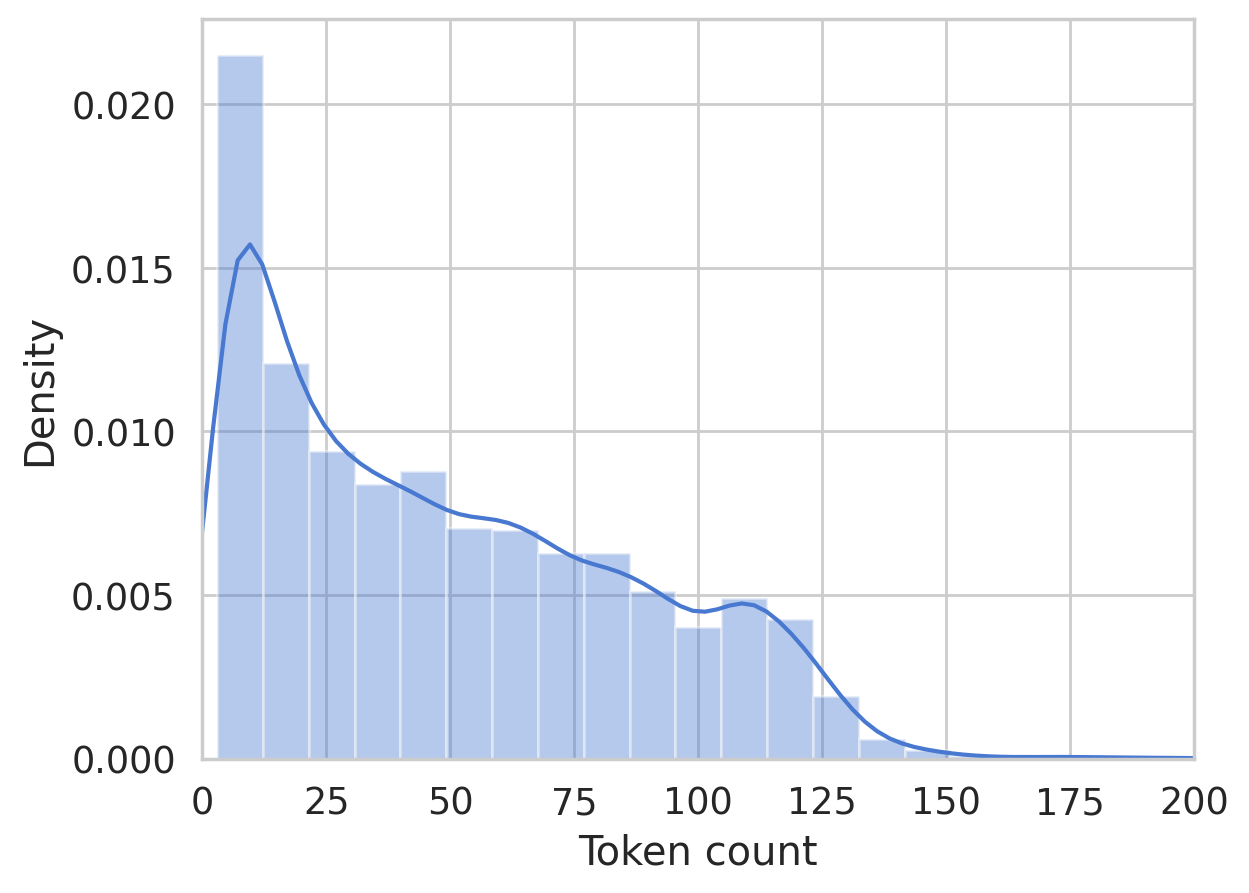

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 160

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((17280, 14), (960, 14), (960, 14))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(train_data_loader)

1080

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Classificação de sentimentos
O classificador irá receber como entrada a última camada de saída do BERT e classificar os sentimentos da sequência de entrada em positivo, negativo ou neutro.

Como todo o trabalho pesado ja foi feito, o classificador será composto apenas de uma camada de dropout para regularização e uma camada totalmente conectada para a saída.

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Treinamento
Com o objetivo de reproduzir o processo de treinamento descrito no artigo do BERT, será utilizada a implementação feita pelo Hugging Face do otimizador Adam (AdamW) e também um scheduler linear, mas sem etapas de warmup.

Para definir os hiperparâmetros do modelo serão utilizadas as recomendações feitas pelos autores do BERT:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
O trecho de código a seguir define esses valores e cria as funções de treinamento e validação do modelo.

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

KeyboardInterrupt: 

Um checkpoint do melhor modelo obtido durante o treinamento foi salvo no arquivo best_model_state.bin. Abaixo, é possível analisar as acurácias de treino e validação.

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Observa-se que ao final das 10 épocas a acurácia de treinamento começa a se aproximar de 100%. Ajustando os parâmetros, o modelo pode ficar ainda melhor, mas esses resultados são suficientes para o propósito desse projeto.

Para avaliar outras métricas, será utilizado o método classification_report do sklearn em conjunto uma função auxiliar para obter as predições.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

A partir das predições realizadas nos dados de teste, pode-se notar que a maioria das métricas associadas ao sentimento neutro ficaram abaixo do observado nos sentimentos positivo e negativo.

Intuitivamente, é possível dizer que os comentário neutros realmente são mais dificeis de ser identificados pois muito do que aparece neles também pode estar presente em frases com teor positivo ou negativo. Esse mesmo resultado pode ser confirmado na matriz de confusão:

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Hora de testar o modelo! Algumas frases aleatórias foram escritas para simular como a solução se comportaria em um cenário real:

In [ ]:
tests = ["Eu gostaria de fazer uma avaliação sincera aqui e ver se o modelo vai identificar. Mas esse é só um teste, \
          então nao consigo dizer se gosto ou nao gosto. Pode ser bom ou pode ser ruim :):(:",

        "Esse aplicativo é muito louco, bem complicado de mexer",

         "Na moral, tá pra nascer app melhor que o Zé delivery!. Bebida sempre gelada e em minutos."
         ]

for test in tests:
  encoded_review = tokenizer.encode_plus(
    test,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  probs = F.softmax(output, dim=1)

  print(f'Review text: {test}')
  print(pd.DataFrame(probs.tolist()[0], class_names)[0])
  print("========================\n")